Import Libraries

In [1]:
is_drive = 0

In [2]:
if is_drive==1 :
    from google.colab import drive
    drive.mount('/content/drive')

In [3]:
# directory management
import os
from glob import glob
import pickle
# regular imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
# audio analysis
import librosa 
import librosa.display
import IPython.display as ipd
# imports for colors and plots
from itertools import cycle
sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])
# imports for NN
import tensorflow as tf
from tensorflow import keras
import time

In [4]:
# Spectogram Path
if is_drive==1 :   
    TRAIN_DIR = "/content/drive/MyDrive/spectogram-dataset/Train/"
    TEST_DIR = "/content/drive/MyDrive/spectogram-dataset/Test/"
    AE_SPECTROGRAMS_SAVE_DIR1 = "/content/drive/MyDrive/autoencoder-generations/Generated-Test/"
    E_SPECTROGRAMS_SAVE_DIR1 = "/content/drive/MyDrive/autoencoder-generations/Compressed-Test/"
    AE_SPECTROGRAMS_SAVE_DIR2 = "/content/drive/MyDrive/autoencoder-generations/Generated-Train/"
    E_SPECTROGRAMS_SAVE_DIR2 = "/content/drive/MyDrive/autoencoder-generations/Compressed-Train/"
else :
    TRAIN_DIR = "../Project/spectogram-dataset/Train/"
    TEST_DIR = "../Project/spectogram-dataset/Test/"
    AE_SPECTROGRAMS_SAVE_DIR1 = "../Project/autoencoder-generations/Generated-Test/"
    E_SPECTROGRAMS_SAVE_DIR1 = "../Project/autoencoder-generations/Compressed-Test/"
    AE_SPECTROGRAMS_SAVE_DIR2 = "../Project/autoencoder-generations/Generated-Train/"
    E_SPECTROGRAMS_SAVE_DIR2 = "../Project/autoencoder-generations/Compressed-Train/"
    MIN_MAX_VALUES_PATH1 = "../Project/MinMax-pickle/Test/min_max_values.pkl"
    MIN_MAX_VALUES_PATH2 = "../Project/MinMax-pickle/Train/min_max_values.pkl"

In [5]:
def load_fsdd(train_spectrograms_path,test_spectrograms_path):
    x_train = []
    train_file_paths = []
    for root, _, file_names in os.walk(train_spectrograms_path):
        for file_name in file_names:
            file_path = os.path.join(root, file_name)
            spectrogram = np.load(file_path) # (n_bins, n_frames)
            x_train.append(spectrogram)
            train_file_paths.append(file_path)
    x_train = np.array(x_train)        # -> (n_samples, n_bins, n_frames)
    x_train = x_train[..., np.newaxis] # -> (1200, 800, 32, 1)

    x_test  = []
    test_file_paths = []
    for root, _, file_names in os.walk(test_spectrograms_path):
        for file_name in file_names:
            file_path = os.path.join(root, file_name)
            spectrogram = np.load(file_path) # (n_bins, n_frames)
            x_test.append(spectrogram)
            test_file_paths.append(file_path)
    x_test = np.array(x_test)        # -> (n_samples, n_bins, n_frames)
    x_test = x_test[..., np.newaxis] # -> (300, 800, 32, 1)

    return x_train,x_test,train_file_paths,test_file_paths

In [6]:
x_train, x_test, train_file_paths, test_file_paths = load_fsdd(TRAIN_DIR, TEST_DIR)

In [7]:
from autoencoder import Autoencoder
from preprocess import Saver
from preprocess import MinMaxNormaliser

In [8]:
AE = Autoencoder.load("AE-model")

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
x_test_generated_spectrograms, x_test_latent_representations = AE.reconstruct(x_test)
print("x_test_latent_representations", x_test_latent_representations.shape)
print("x_test_generated_spectrograms", x_test_generated_spectrograms.shape)
x_train_generated_spectrograms, x_train_latent_representations = AE.reconstruct(x_train)
print("x_train_latent_representations", x_train_latent_representations.shape)
print("x_train_generated_spectrograms", x_train_generated_spectrograms.shape)

c:\Users\Ali\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


x_test_latent_representations (300, 16)
x_test_generated_spectrograms (300, 160, 84, 1)
x_train_latent_representations (1200, 16)
x_train_generated_spectrograms (1200, 160, 84, 1)


In [10]:
saver1 = Saver(AE_SPECTROGRAMS_SAVE_DIR1, None)
saver2 = Saver(E_SPECTROGRAMS_SAVE_DIR1, None)
saver3 = Saver(AE_SPECTROGRAMS_SAVE_DIR2, None)
saver4 = Saver(E_SPECTROGRAMS_SAVE_DIR2, None)
for i in range(len(x_test_generated_spectrograms)):
    saver1.save_feature(x_test_generated_spectrograms[i], test_file_paths[i])
    saver2.save_feature(x_test_latent_representations[i], test_file_paths[i])
for i in range(len(x_train_generated_spectrograms)):
    saver3.save_feature(x_train_generated_spectrograms[i], train_file_paths[i])
    saver4.save_feature(x_train_latent_representations[i], train_file_paths[i])

In [11]:
# load spectrograms + min max values
with open(MIN_MAX_VALUES_PATH1, "rb") as f:
    test_min_max_values = pickle.load(f)

sampled_min_max_values = [test_min_max_values[file_path] for file_path in train_file_paths]

In [13]:
min_max_normaliser = MinMaxNormaliser(0, 1)
denorm_log_specs = []
for spectrogram, min_max_value in zip(x_test_generated_spectrograms, sampled_min_max_values):
    # reshape the log spectrogram
    log_spectrogram = spectrogram[:, :, 0]
    # apply denormalisation
    denorm_log_spec = min_max_normaliser.denormalise(
        log_spectrogram, min_max_value["min"], min_max_value["max"])
    # 
    denorm_log_specs.append(log_spectrogram)

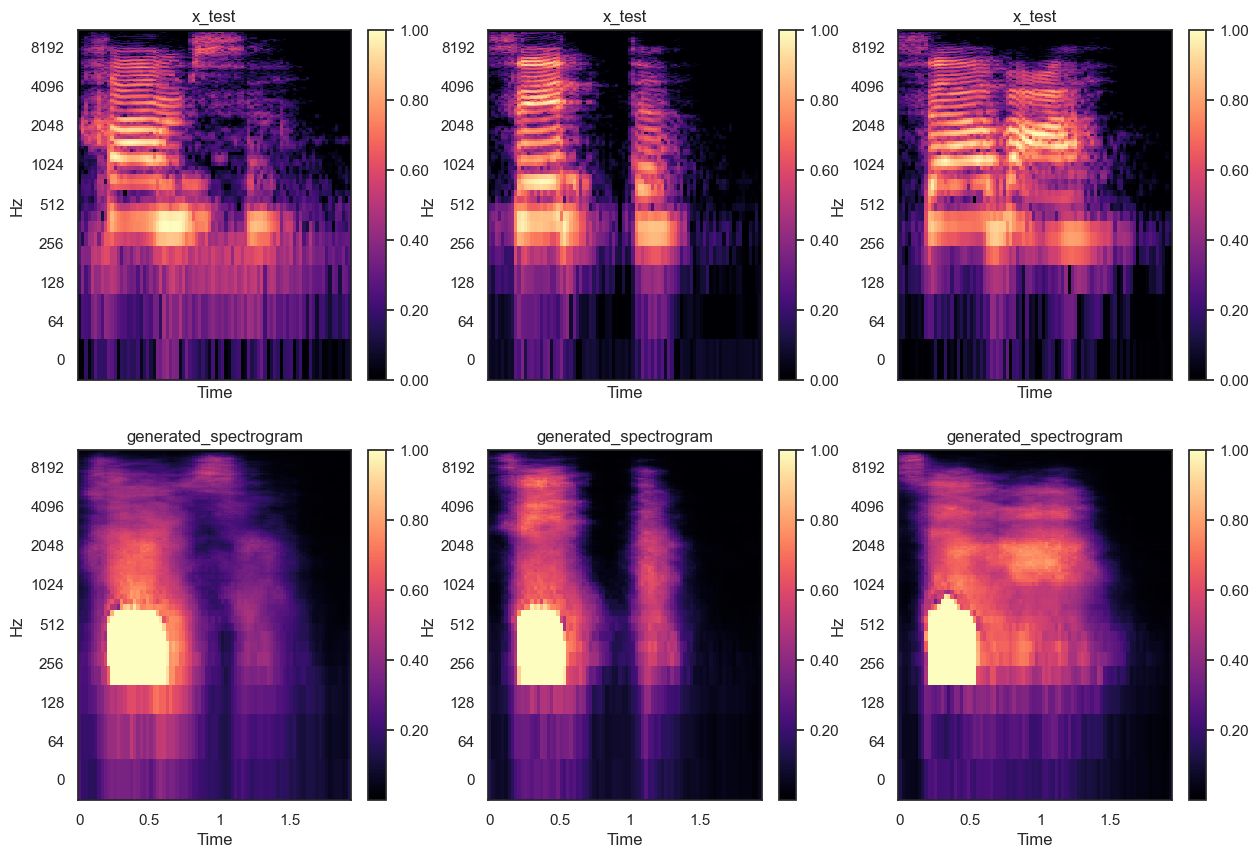

In [14]:
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=True, figsize=(15,10))
for i in range(3):
    img1 = librosa.display.specshow(x_test[i+5].reshape(160, 84),
                                x_axis='time',
                                y_axis='log',
                                ax=ax[0, i])
    ax[0, i].set(title='x_test')
    fig.colorbar(img1, ax=ax[0, i], format=f'%0.2f')
    img = librosa.display.specshow(x_test_generated_spectrograms[i+5].reshape(160, 84),
                                x_axis='time',
                                y_axis='log',
                                ax=ax[1, i])
    ax[1, i].set(title='generated_spectrogram')
    fig.colorbar(img, ax=ax[1, i], format=f'%0.2f')
plt.show()

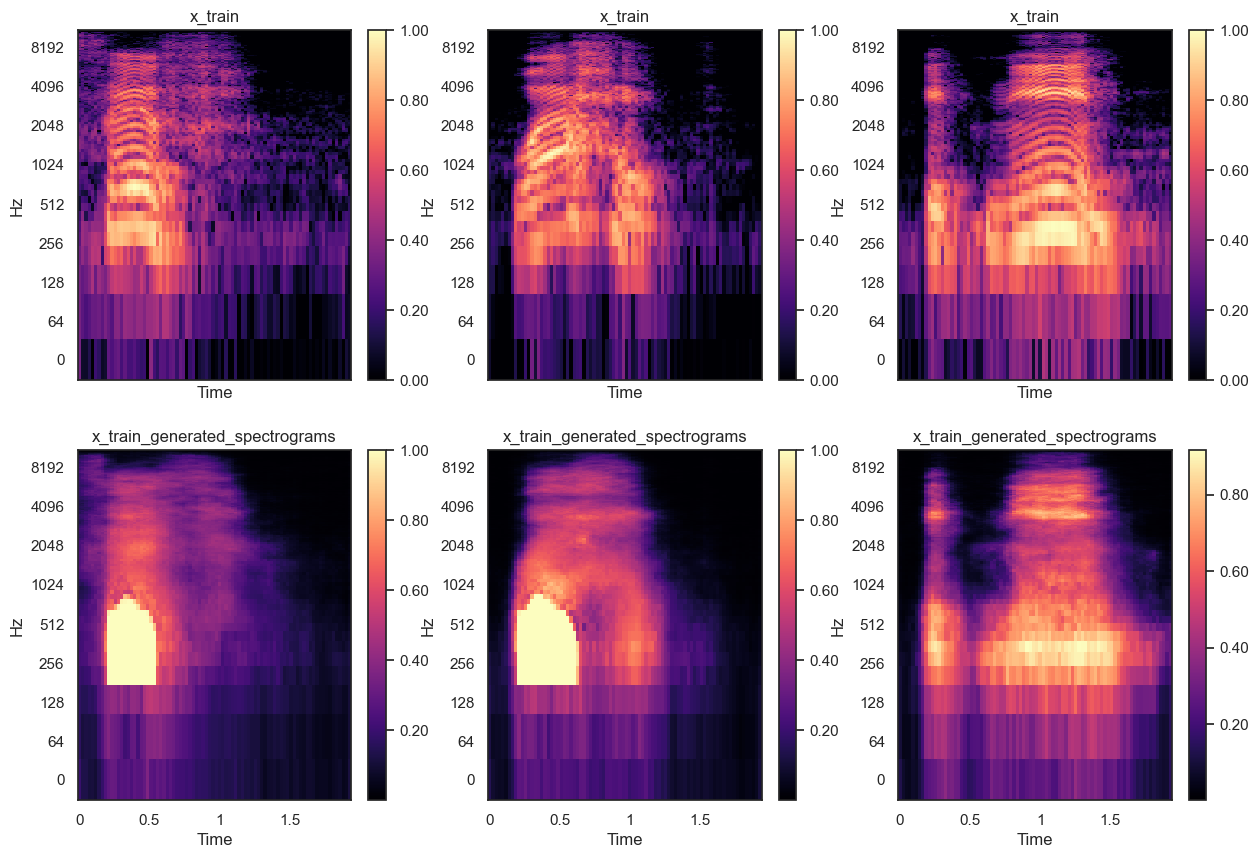

In [15]:
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=True, figsize=(15,10))
for i in range(3):
    img1 = librosa.display.specshow(x_train[i+100].reshape(160, 84),
                                x_axis='time',
                                y_axis='log',
                                ax=ax[0, i])
    ax[0, i].set(title='x_train')
    fig.colorbar(img1, ax=ax[0, i], format=f'%0.2f')
    img = librosa.display.specshow(x_train_generated_spectrograms[i+100].reshape(160, 84),
                                x_axis='time',
                                y_axis='log',
                                ax=ax[1, i])
    ax[1, i].set(title='x_train_generated_spectrograms')
    fig.colorbar(img, ax=ax[1, i], format=f'%0.2f')
plt.show()